In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
# for interactive plots replace 'inline' with 'widget' and run in standalone jupyter notebook/lab
import os
from sepia.SepiaModelSetup import setup_model
from sepia.SepiaData import SepiaData as SepiaData
import numpy as np
import sepia.SepiaPlot as SepiaPlot
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from nedderimp import nedderimp
from scipy.interpolate import interp2d
from copy import deepcopy

def dist2pi(x1,x2):
    # computes the distance assuming periodicity: 2pi=0
    # x1 and x2 are vectors with common length and values
    # between 0 and 2pi
    d = abs(x1-x2)
    iwrap = d > np.pi
    d[iwrap] = 2*np.pi - d[iwrap]
    return(d)
def dnorm(x,mu,scale):  
    # normal density in 1-d. 
    # It is scaled so that the 1-d integral is 1
    # mu and scale are scalars, x is an array...
    out=np.zeros(len(x))
    u=abs(x-mu)/scale
    out = (1.0/(np.sqrt(2*np.pi)*scale)) * np.exp(-.5 * u**2)
    return(out)

In [2]:
# simulation design
design = np.array([
    [0.7714,    0.4286,    0.0286],
    [0.3714,    0.1143,    0.7143],
    [0.1714,    0.4571,    0.8857],
    [0.3429,    0.6000,    0.8000],
    [0.8000,    0.6286,    0.4000],
    [0.7429,    0.5429,         0],
    [0.6571,    1.0000,    0.6286],
    [0.2857,         0,    0.4571],
    [0.5143,    0.9429,    0.2286],
    [0.6857,    0.3143,    0.6571],
    [0.8286,    0.2000,    1.0000],
    [0.9714,    0.3429,    0.6000],
    [0.4000,    0.8000,    0.2000],
    [0.5429,    0.2857,    0.2857],
    [0.9143,    0.8857,    0.2571],
    [0.0571,    0.0286,    0.0857],
    [0.1143,    0.5714,    0.7429],
    [0.2000,    0.2286,    0.3714],
    [0.4571,    0.9143,    0.3429],
    [0.6286,    0.7143,    0.6857],
    [     0,    0.8286,    0.9429],
    [0.8857,    0.0857,    0.9714],
    [0.2286,    0.0571,    0.5714],
    [0.7143,    0.1714,    0.8571],
    [0.2571,    0.4857,    0.1429],
    [0.5714,    0.4000,    0.8286],
    [0.9429,    0.6857,    0.4857],
    [0.4857,    0.1429,    0.1143],
    [1.0000,    0.8571,    0.9143],
    [0.6000,    0.6571,    0.5143],
    [0.1429,    0.7429,    0.5429],
    [0.8571,    0.2571,    0.0571],
    [0.3143,    0.3714,    0.4286],
    [0.4286,    0.7714,    0.7714],
    [0.0286,    0.9714,    0.3143],
    [0.0857,    0.5143,    0.1714]])

# number of experiements and simulations
n = 3; m = design.shape[0]

# these parameter values simulate expt 10 in Neddermeyer '43
# params =             [R1      lam     s         rho   mratio   u0]
params10 = np.array([1.5*2.54, 2/3,  3e5*6.84e4,  7.5,   .32,   1.65e10])
paramslhs = np.zeros((m, 6))
for i in range(m):#
    paramslhs[i,:] = params10*np.array([1, 1, design[i,1]*.2+.9, 1, design[i,0]*.65+.5, design[i,2]*.2+.9])
# the simulation runs will vary mratio from .32*[.5 to 1.15]
#                                s      from s0*[.9 to 1.1]
#                                u0     from u0*[.9 to 1.1]

### A plot of the implosion over time

In [3]:
nt = 22; nphi = 26
time = np.c_[np.linspace(0,5.0e-5,nt,endpoint=True)]
phi = np.linspace(0,1,nphi,endpoint=True) * 2*np.pi;
rinner = nedderimp(time,params10);
lam = params10[1]; R1 = params10[0];
router = np.sqrt(rinner**2 + 1 - lam**2);
xycirc = np.array([np.cos(phi),np.sin(phi)]).T
r = nedderimp(time,params10);

# Generate simulation data

In [4]:
yr = np.zeros((m,nt))
for i in range(m):
    params = paramslhs[i,:]
    yr[i,:] = params[0]*nedderimp(time,params)

y_sim = np.tile(yr,nphi)
# indices
y_sim_ind_time_phi = np.zeros((22*26,2))
y_sim_ind_time_phi[:,0] = np.repeat(time,26)
y_sim_ind_time_phi[:,1] = np.tile(phi,22)
x_sim = design[:,0].reshape(m,1)
t_sim = design[:,1:3]

# Generate observed data

In [5]:
phi_obs = np.arange(0,(2*np.pi-.1),(2*np.pi/16))
n_phi_obs = phi_obs.shape[0]
time_obs = [np.array([1.5e-5, 2.7e-5, 4.5e-5]),np.array([4.5e-5]),np.array([2.5e-5, 4.5e-5])]
n_time_obs = [tmp.shape[0] for tmp in time_obs]

phiknots = np.arange(0,2*np.pi-.1,2*np.pi/8)
dknots = np.expand_dims(np.array([.04, -.03, .03, -.03, .02, -.03, .03, -.03]),1)*2.5
pphiknots = len(phiknots)
Ddelt = np.zeros((phi_obs.shape[0], pphiknots));
datadelt = np.matmul(Ddelt,dknots)

# observations
r_obs = [None]*3; y_obs = [None]*3
for i in range(3):
    obs_params = deepcopy(params10)
    if i==1: obs_params[4]=.17
    elif i==2: obs_params[4]=.36
    r_obs[i] = np.atleast_2d(obs_params[0]*nedderimp(time_obs[i],obs_params))
    y_obs[i] = np.tile(r_obs[i].T,phi_obs.shape[0]).reshape(n_phi_obs,n_time_obs[i]) + np.tile(datadelt,n_time_obs[i])
    y_obs[i] = (y_obs[i] + .01*np.random.normal(size=y_obs[i].shape)).flatten()

# indices of observations
x_obs = ((np.array([params10[4], .17, .36])/.32-.5)/.65).reshape(3,1)
y_ind_obs = [np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[0][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[0][1],\
                                       np.ones(phi_obs.shape[0])*time_obs[0][2])), np.tile(phi_obs,3).T ) ),
                np.column_stack( ( (np.ones(phi_obs.shape[0])*time_obs[1]).reshape(16,1), phi_obs.T ) ),
                np.column_stack( ( np.concatenate((np.ones(phi_obs.shape[0])*time_obs[2][0],\
                                   np.ones(phi_obs.shape[0])*time_obs[2][1])), np.tile(phi_obs,2).T ) )]

### Sepia Data

In [6]:
data = SepiaData(x_sim = x_sim, t_sim = t_sim, y_sim = y_sim, y_ind_sim = y_sim_ind_time_phi,\
                 x_obs = x_obs, y_obs = y_obs, y_ind_obs = y_ind_obs)
data.transform_xt()

### K basis

In [7]:
# sim
ysimmean = np.mean(y_sim,0)
ysimsd = np.std(y_sim)
ysimStd = (y_sim - np.tile(ysimmean,m).reshape(y_sim.shape))/ysimsd
data.sim_data.orig_y_mean = ysimmean
data.sim_data.orig_y_sd = ysimsd
data.sim_data.y_std = ysimStd
# now represent ye images using eof's
U, s, V = np.linalg.svd(ysimStd.T, full_matrices=False)
numPC = 3
data.sim_data.K = U[:,0:numPC]*s[0:numPC]/np.sqrt(m)
data.sim_data.K = data.sim_data.K.T

# obs
phimat = np.repeat(phi,nt).reshape((nt,nphi),order='F')
timemat = np.repeat(time,nphi).reshape((nt,nphi))
# compute simulator mean values simdat.ymean interpolated to the data values...
interp_func = interp2d(phimat[0,:],timemat[:,0],data.sim_data.orig_y_mean.reshape((nt,nphi),order='F'))
data.obs_data.orig_y_mean = []
data.obs_data.orig_y_sd = []
for k in range(n):
    ymk = interp_func(np.unique(data.obs_data.y_ind[k][:,1]),np.unique(data.obs_data.y_ind[k][:,0]))                                                                             
    data.obs_data.orig_y_mean.append(ymk.flatten())
    data.obs_data.orig_y_sd.append(data.sim_data.orig_y_sd)

# now compute the centered, scaled observed arrival times yStd
data.obs_data.y_std = []
for k in range(n):
    data.obs_data.y_std.append((data.obs_data.y[k] - data.obs_data.orig_y_mean[k])/data.sim_data.orig_y_sd)

data.obs_data.K = []
for k in range(n):
    data.obs_data.K.append(np.zeros((data.obs_data.y_std[k].shape[0], numPC)))
    for j in range(numPC):
        f = interp2d(phimat[0,:],timemat[:,0],np.reshape(data.sim_data.K[j,:],(nt,nphi),order='F'))
        data.obs_data.K[k][:,j] = f(data.obs_data.y_ind[k][:,1],data.obs_data.y_ind[k][:,0])[:,0]

for k in range(n):
    data.obs_data.K[k] = data.obs_data.K[k].T

In [8]:
### D basis

In [9]:
# compute the basis functions for the discrepancy function.
Dsim  = np.zeros((phi.shape[0], pphiknots))
for k in range(pphiknots):
    Ddelt[:,k] = dnorm(dist2pi(phi_obs,phiknots[k]*np.ones(phi_obs.shape[0])),0,np.pi/8).T;
    x = dist2pi(phi,phiknots[k]*np.ones(phi.shape[0])).flatten()
    Dsim[:,k] = dnorm(x=x,mu=0,scale=np.pi/8)

simdelt = np.matmul(Dsim,dknots)
timeknots = np.linspace(0,.5,3)*1e-4
ptimeknots=len(timeknots)
data.obs_data.D = []
for k in range(n):
    knotlocstime = np.reshape(np.repeat(timeknots,pphiknots),(ptimeknots*pphiknots, 1))
    knotlocsphi = np.expand_dims(np.tile(phiknots,ptimeknots),1)
    pv = knotlocstime.shape[0]
    Dobs = np.zeros((data.obs_data.y_std[k].shape[0], pv))
    if k == 0: Dsim = np.zeros((data.sim_data.y_std.shape[1], pv))
    for j in range(pv):
        Dobs[:,j] = dnorm(y_ind_obs[k][:,0],knotlocstime[j],.25*1e-4)*\
            dnorm(dist2pi(y_ind_obs[k][:,1],knotlocsphi[j]*np.ones(y_ind_obs[k][:,1].shape[0])),0,np.pi/8)
        if k == 0:
            Dsim[:,j] = dnorm(timemat.flatten('F'),knotlocstime[j],.25*1e-4)*\
                dnorm(dist2pi(phimat.flatten('F'),knotlocsphi[j]*np.ones(len(phimat.flatten()))),0,np.pi/8)
    if k == 0: data.sim_data.D = Dsim
    data.obs_data.D.append(Dobs.T)
# now normalize Dobs and Dsim so that it gives a var=1 process
dmax = np.amax(np.amax(np.matmul(data.sim_data.D,data.sim_data.D.T)))
for k in range(n):
    data.obs_data.D[k] /= np.sqrt(dmax)
data.sim_data.D /= np.sqrt(dmax)

# No optimization, use step size tuning

In [59]:
print(data)
model = setup_model(data)

This SepiaData instance implies the following:
This is a simulator and obs model, sim y dimension 572, obs y dimension ragged
n  =     3 (number of observed data)
m  =    36 (number of simulated data)
p  =     1 (number of inputs)
q  =     2 (number of additional simulation inputs to calibrate)
pu =     3 (transformed response dimension)
pv =    24 (transformed discrepancy dimension)



In [60]:
override=0
cachefile_name='neddermeyer_nooptim.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model=pickle.load(open(cachefile_name, "rb" ))
else:
    model.tune_step_sizes(50, 20, update_vals=True)
    model.do_mcmc(5000)
    pickle.dump(model, open( cachefile_name, "w+b" ))

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1199.5072889]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.1415752  0.17772463]]
betaV
[[1.40077131]]
betaU
[[0.73169592 0.37599865 1.1692406 ]
 [0.06209454 0.58787928 0.16876396]
 [0.07520104 0.55340755 0.6502744 ]]
lamVz
[[17936.93845058]]
lamUz
[[0.83348977 0.64987049 1.04097869]]
lamWs
[[3371.55148934 3401.09761349 4569.69020439]]
lamWOs
[[3548.36696659]]
lamOs
[[3932.06995917]]


MCMC sampling: 100%|██████████| 5000/5000 [01:00<00:00, 82.57it/s]


PicklingError: Can't pickle <class 'sepia.SepiaModel.SepiaModel'>: it's not the same object as sepia.SepiaModel.SepiaModel

Max effective sample size over thetas: 301
Total samples: 5000


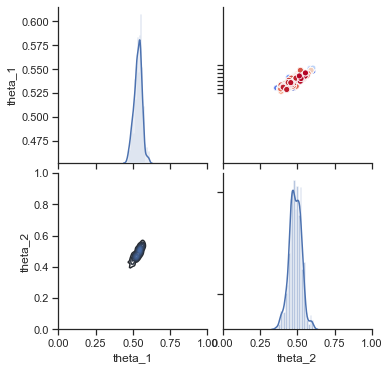

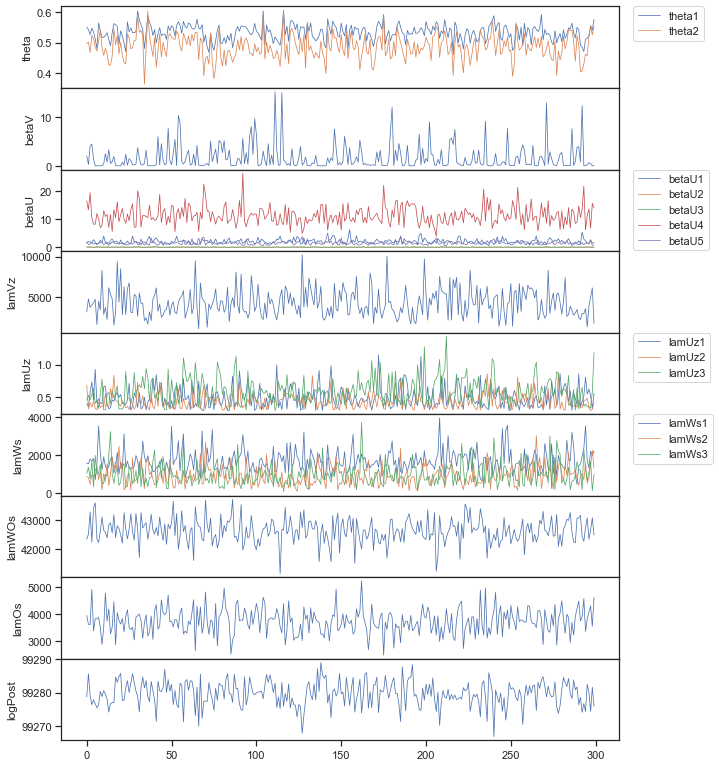

In [81]:
samples_dict = model.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict)
SepiaPlot.mcmc_trace(samples_dict,start=0,n_to_plot=1000,max_print=5)

In [62]:
# get 5/95 quantiles for logPost
qLP = np.quantile(samples_dict['logPost'],(.2,.8))
print(qLP)
lpMean = np.mean(samples_dict['logPost'])
print(lpMean)

[99276.64544214 99283.01004292]
99279.70041049767


# Optimization and step size tuning

In [63]:
model2 = setup_model(data)
opt_prm, history, p_hist = model2.optim_logPost(maxiter=10000,xatol=10,fatol=10)

optimizing logpost over all parameters
Optimization terminated successfully.
         Current function value: -98221.845332
         Iterations: 435
         Function evaluations: 727
  param  init value  opt value
  theta    0.500000   0.526552
  theta    0.500000   0.546703
  betaV    0.100000   0.105176
  betaU    0.100000   0.103406
  betaU    0.100000   0.102681
  betaU    0.100000   0.103297
  betaU    0.100000   0.114619
  betaU    0.100000   0.107162
  betaU    0.100000   0.103418
  betaU    0.100000   0.105868
  betaU    0.100000   0.108753
  betaU    0.100000   0.100741
  lamVz    2.995732   3.117775
  lamUz    1.000000   1.011962
  lamUz    1.000000   0.996145
  lamUz    1.000000   1.025086
  lamWs    6.907755   7.191070
  lamWs    6.907755   4.094960
  lamWs    6.907755   4.103057
 lamWOs   10.660909  10.661185
  lamOs    7.782813   7.894987


In [64]:
override=0
cachefile_name='neddermeyer_optim.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model2=pickle.load(open(cachefile_name, "rb" ))
else:
    model2.tune_step_sizes(50, 20, update_vals=False)
    model2.do_mcmc(5000)
    pickle.dump(model2, open( cachefile_name, "w+b" ))

Step size tuning:   0%|          | 0/50 [00:00<?, ?it/s]

Starting tune_step_sizes...
Default step sizes:
theta
[[0.2 0.2]]
betaV
[[0.1]]
betaU
[[0.1 0.1 0.1]
 [0.1 0.1 0.1]
 [0.1 0.1 0.1]]
lamVz
[[10.]]
lamUz
[[5. 5. 5.]]
lamWs
[[100. 100. 100.]]
lamWOs
[[100.]]
lamOs
[[1199.5072889]]


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Done with tune_step_size.
Selected step sizes:
theta
[[0.12242034 0.20117732]]
betaV
[[1.89776834]]
betaU
[[1.07903738 0.39991311 0.59292871]
 [0.05075981 0.70461919 0.33658701]
 [0.08250403 0.39990854 0.70681234]]
lamVz
[[32695.72430383]]
lamUz
[[0.74745085 0.66267618 0.8352996 ]]
lamWs
[[4205.5695343  4094.60763195 3875.12061384]]
lamWOs
[[4786.82787547]]
lamOs
[[5160.29593335]]


MCMC sampling: 100%|██████████| 5000/5000 [01:01<00:00, 81.77it/s]


PicklingError: Can't pickle <class 'sepia.SepiaModel.SepiaModel'>: it's not the same object as sepia.SepiaModel.SepiaModel

Max effective sample size over thetas: 113
Total samples: 5000


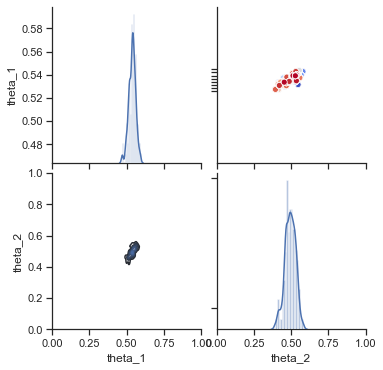

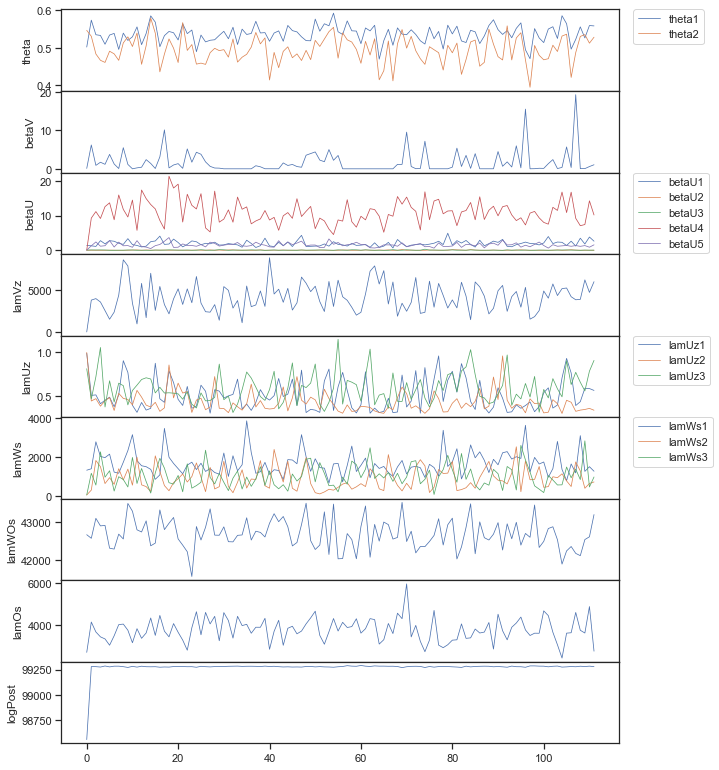

In [79]:
samples_dict2 = model2.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict2)
SepiaPlot.mcmc_trace(samples_dict2,start=0,n_to_plot=1000,max_print=5)

# no optimization or step size tunings

In [69]:
model3 = setup_model(data)
override=0
cachefile_name='neddermeyer_noopt_nostep.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model3=pickle.load(open(cachefile_name, "rb" ))
else:
    #model3.tune_step_sizes(50, 20, update_vals=False)
    model3.do_mcmc(5000)
    pickle.dump(model3, open( cachefile_name, "w+b" ))

MCMC sampling: 100%|██████████| 5000/5000 [01:05<00:00, 76.66it/s]


PicklingError: Can't pickle <class 'sepia.SepiaModel.SepiaModel'>: it's not the same object as sepia.SepiaModel.SepiaModel

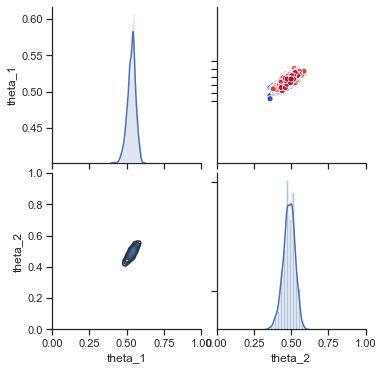

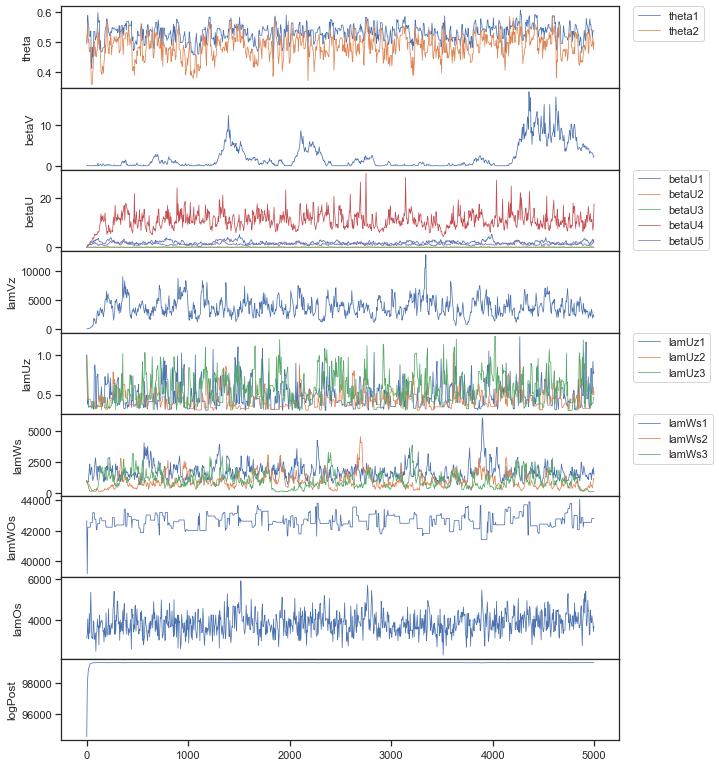

In [76]:
samples_dict3 = model3.get_samples(effectivesamples=False)
SepiaPlot.theta_pairs(samples_dict3)
SepiaPlot.mcmc_trace(samples_dict3,start=0,n_to_plot=1000,max_print=5)

# optimization no step size tuning

In [72]:
model4 = setup_model(data)
_ = model4.optim_logPost(maxiter=10000,xatol=10,fatol=10)
override=0
cachefile_name='neddermeyer_opt_nostep.pkl'
import os.path
import pickle
if os.path.isfile(cachefile_name) and override==0:
    model4=pickle.load(open(cachefile_name, "rb" ))
else:
    #model4.tune_step_sizes(50, 20, update_vals=False)
    model4.do_mcmc(5000)
    pickle.dump(model4, open( cachefile_name, "w+b" ))

optimizing logpost over all parameters


MCMC sampling:   0%|          | 0/5000 [00:00<?, ?it/s]

Optimization terminated successfully.
         Current function value: -98221.845332
         Iterations: 435
         Function evaluations: 727
  param  init value  opt value
  theta    0.500000   0.526552
  theta    0.500000   0.546703
  betaV    0.100000   0.105176
  betaU    0.100000   0.103406
  betaU    0.100000   0.102681
  betaU    0.100000   0.103297
  betaU    0.100000   0.114619
  betaU    0.100000   0.107162
  betaU    0.100000   0.103418
  betaU    0.100000   0.105868
  betaU    0.100000   0.108753
  betaU    0.100000   0.100741
  lamVz    2.995732   3.117775
  lamUz    1.000000   1.011962
  lamUz    1.000000   0.996145
  lamUz    1.000000   1.025086
  lamWs    6.907755   7.191070
  lamWs    6.907755   4.094960
  lamWs    6.907755   4.103057
 lamWOs   10.660909  10.661185
  lamOs    7.782813   7.894987


MCMC sampling: 100%|██████████| 5000/5000 [01:05<00:00, 75.85it/s]


PicklingError: Can't pickle <class 'sepia.SepiaModel.SepiaModel'>: it's not the same object as sepia.SepiaModel.SepiaModel

Max effective sample size over thetas: 134
Total samples: 5000


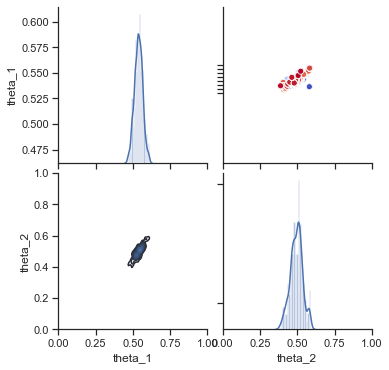

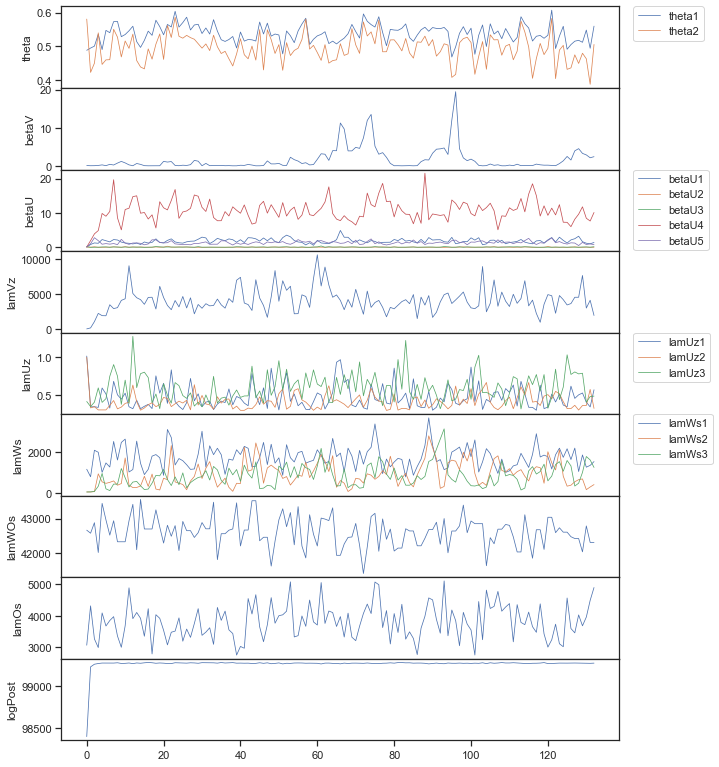

In [80]:
samples_dict4 = model4.get_samples(effectivesamples=True)
SepiaPlot.theta_pairs(samples_dict4)
SepiaPlot.mcmc_trace(samples_dict4,start=0,n_to_plot=1000,max_print=5)

# Diagnostics

In [66]:
# get theta history
theta_history = np.zeros((len(p_hist),2))
for i in range(len(p_hist)):
    theta_history[i,:] = p_hist[i][0:2]

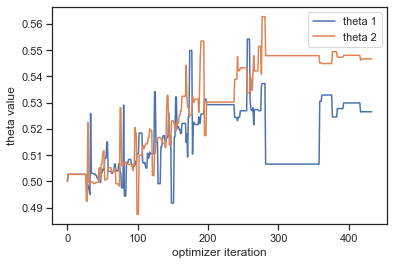

In [67]:
# plot theta history by iteration
plt.plot(theta_history[:,0],label='theta 1')
plt.plot(theta_history[:,1],label='theta 2')
plt.xlabel('optimizer iteration')
plt.ylabel('theta value')
plt.legend()
plt.savefig('optim_theta_from_pt5.jpg',dpi=300)
plt.show()

In [50]:
for i, k in enumerate(samples_dict.keys()):
    for j in range(samples_dict[k].shape[1]):
        print(k,np.mean(samples_dict[k][:,j]))

theta 0.5377382370079296
theta 0.4997584903538862
betaV 1.6238249106770872
betaU 1.9500204782173924
betaU 0.06566735767300365
betaU 0.10041244424622787
betaU 10.649230433137165
betaU 1.6573287139931199
betaU 0.7251085156356663
betaU 9.553318191272961
betaU 10.023834911929697
betaU 1.008169909990418
lamVz 3374.3884086593634
lamUz 0.4924794204577698
lamUz 0.4473934880304882
lamUz 0.5509571202473166
lamWs 1675.8549618177692
lamWs 941.0310927210755
lamWs 944.5633775898805
lamWOs 42659.99708710185
lamOs 3353.855968241771
logPost 99270.54712847913


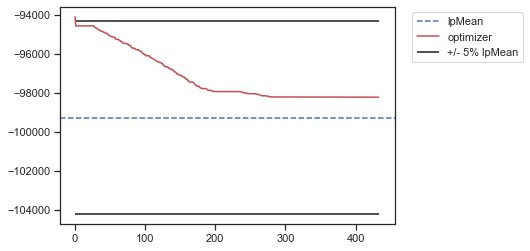

In [78]:
plt.hlines([-lpMean*1.05,-lpMean*.95],label='+/- 5% lpMean',xmin=0,xmax=len(history))
plt.axhline(-lpMean,c='b',linestyle='--',label='lpMean',xmin=0,xmax=len(history))
plt.plot(history,c='r',label='optimizer')
plt.legend(bbox_to_anchor=(1.4, 1))
plt.show()